In [710]:
import os
import glob
from pathlib import Path
import numpy as np
import torch
# import cv2
import open3d as o3d
from open3d import JVisualizer
import trimesh
import matplotlib.pyplot as plt
# import scipy.signal as signal
# from tqdm import tqdm
# import multiprocessing as mp

# from vgn.grasp import Grasp, Label
from vgn.io import *
from vgn.perception import *
from vgn.simulation import ClutterRemovalSim
from vgn.utils.transform import Rotation, Transform
from vgn.utils.implicit import get_scene_from_mesh_pose_list, as_mesh
from vgn.utils.misc import apply_noise
from vgn.grasp_sampler import GpgGraspSamplerPcl
from vgn.networks import get_network, load_network

# seed = np.random.randint(2**32 - 1)
nice_seeds = [2744579596, 3736952697, 1570237463, 3573398670, 3090687052]
great_scene_forscene_recon = [2837027833, 1075486976]
seed = nice_seeds[4]
np.random.seed(seed)

constructed_root = Path("/home/sjauhri/IAS_WS/potato-net/GIGA-TSDF/GIGA-6DoF/data/pile/data_pile_train_constructed_4M_HighRes_radomized_views_GPG_only")
model_type = "neu_grasp_pn_deeper"
# model_path = "/home/sjauhri/IAS_WS/potato-net/GIGA-TSDF/GIGA-6DoF/data/runs_relevant/23-05-07-10-46-43_dataset=data_packed_train_constructed_4M_GPG_60_randomized_view_no_tab_packked,augment=False,net=6d_neu_grasp_pn_deeper,batch_size=32,lr=5e-05,PN_deeper_no_tab_WITH_occ_PACKED/best_neural_grasp_neu_grasp_pn_deeper_val_acc=0.9317.pt"
# model_path="/home/sjauhri/IAS_WS/potato-net/GIGA-TSDF/GIGA-6DoF/data/runs_relevant/23-05-03-01-42-37_dataset=data_pile_train_constructed_4M_HighRes_radomized_views_no_table,augment=False,net=6d_neu_grasp_pn_deeper,batch_size=32,lr=5e-05,PN_no_tab_deeper_DIMS_WITH_occ/best_neural_grasp_neu_grasp_pn_deeper_val_acc=0.9120.pt"
model_path = "/home/sjauhri/IAS_WS/potato-net/GIGA-TSDF/GIGA-6DoF/data/runs_relevant/23-05-01-08-11-39_dataset=data_pile_train_constructed_4M_HighRes_radomized_views,augment=False,net=6d_neu_grasp_pn_deeper,batch_size=32,lr=5e-05,PN_deeper_DIMS_CONT/best_neural_grasp_neu_grasp_pn_deeper_val_acc=0.9097.pt"
see_table = True
device = "cuda"
net = load_network(model_path, device, model_type)

# previous_root = "/home/sjauhri/IAS_WS/potato-net/GIGA-TSDF/GIGA-6DoF/data/packed/packed_data_for_pngpd"
previous_root="/home/sjauhri/IAS_WS/potato-net/GIGA-TSDF/GIGA-6DoF/data/pile/data_pile_train_random_raw_4M_radomized_views/"
data_root = "/home/sjauhri/IAS_WS/potato-net/GIGA-TSDF/GIGA-6DoF/"

sim_gui = False
three_cameras = True # Use one camera for wrist and two cameras for the fingers
add_noise = False # Add dex noise to the rendered images like GIGA
noise_type = 'mod_dex'
gp_rate = 0.5 # Rate of applying Gaussian process noise
voxel_downsample_size = 0.002 # 2mm
scene_voxel_downsample_size = 0.005 # 5mm
max_points = 1023
resolution = 64
scene='pile'
object_set='pile/train'
size=0.3

## Re-create the saved simulation
# Get random scene
index = np.random.randint(32000) # index 20 is a good example.
mesh_list_files = glob.glob(os.path.join(previous_root, 'mesh_pose_list', '*.npz'))
mesh_pose_list = np.load(mesh_list_files[index], allow_pickle=True)['pc']
scene_id = os.path.basename(mesh_list_files[index])[:-4] # scene id without .npz extension
## Get specific scene
# scene_id = 'f614e39ed9df4e1094d569cddc20979b'
# mesh_list_file = os.path.join(previous_root, 'mesh_pose_list', scene_id + '.npz')
# mesh_pose_list = np.load(mesh_list_file, allow_pickle=True)['pc']

sim = ClutterRemovalSim(scene, object_set, gui=sim_gui, data_root=data_root) # parameters scene and object_set are not used
sim.setup_sim_scene_from_mesh_pose_list(mesh_pose_list, table=see_table, data_root=data_root) # Setting table to False because we don't want to render it
# sim.save_state()

# Get scene point cloud and normals using ground truth meshes
scene_mesh = get_scene_from_mesh_pose_list(mesh_pose_list, data_root=data_root)
o3d_scene_mesh = scene_mesh.as_open3d
o3d_scene_mesh.compute_vertex_normals()
pc = o3d_scene_mesh.sample_points_uniformly(number_of_points=1000)
points = np.asarray(pc.points)
# pc_trimesh = trimesh.points.PointCloud(points)
# pc_colors = np.array([trimesh.visual.random_color() for i in points])
# pc_trimesh.vertices_color = pc_colors
# trimesh.Scene([scene_mesh, pc_trimesh]).show()
# o3d.visualization.draw_geometries([pc])
visualizer = JVisualizer()
# pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0, 0, 0]), (np.asarray(pc.points).shape[0], 1)))
# visualizer.add_geometry(pc)
# visualizer.show()

trimesh.Scene([scene_mesh]).show()

Loading [neu_grasp_pn_deeper] model from /home/sjauhri/IAS_WS/potato-net/GIGA-TSDF/GIGA-6DoF/data/runs_relevant/23-05-01-08-11-39_dataset=data_pile_train_constructed_4M_HighRes_radomized_views,augment=False,net=6d_neu_grasp_pn_deeper,batch_size=32,lr=5e-05,PN_deeper_DIMS_CONT/best_neural_grasp_neu_grasp_pn_deeper_val_acc=0.9097.pt


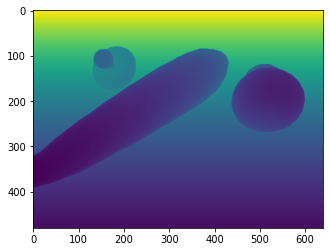

In [711]:
# Render depth image from random viewpoint or hard viewpoint
def render_n_images(sim, n=1, random=False, tight=False, noise_type=''):
    origin = Transform(Rotation.identity(), np.r_[size / 2, size / 2, 0.0])
    if random:
        if tight:
            theta = np.random.uniform(5.5*np.pi/12.0)
        theta = np.random.uniform(np.pi / 12.0, 5* np.pi / 12.0) # elevation: 15 to 75 degrees

        # theta = np.random.uniform(5*np.pi/12.0)
        # 75 degree reconstruction is unrealistic, try 60
        # theta = np.random.uniform(np.pi/3)
        # theta = np.random.uniform(np.pi/6, np.pi/4) # elevation: 30 to 45 degrees
        r = np.random.uniform(2.0) * size
    else:
        # theta = np.random.uniform(np.pi / 18.0, np.pi / 4.5) # SJ EDIT!!! random 10 to 40 degrees from top view
        theta = np.pi / 4.0 # 45 degrees from top view
        r = 2.0 * size
    
    phi_list = 2.0 * np.pi * np.arange(n) / n # circle around the scene
    extrinsics = [camera_on_sphere(origin, r, theta, phi) for phi in phi_list]
    depth_imgs = []

    for extrinsic in extrinsics:
        # Multiple views -> for getting other sides of pc
        depth_img = sim.camera.render(extrinsic)[1]
        # add noise
        depth_img = apply_noise(depth_img, noise_type)
        
        depth_imgs.append(depth_img)

    return depth_imgs, extrinsics

# Get random scene image:
depth_imgs, extrinsics = render_n_images(sim, n=1, random=True, tight=True, noise_type='')
plt.imshow(depth_imgs[0]) # Normally too far away to see anything

In [712]:
# Make tsdf and pc from the image
tsdf = TSDFVolume(size, resolution)
for depth_img, extrinsic in zip(depth_imgs, extrinsics):
    tsdf.integrate(depth_img, sim.camera.intrinsic, extrinsic)
seen_pc = tsdf.get_cloud()
# Optional: Crop out table
lower = np.array([0.0 , 0.0 , 0.055])
upper = np.array([size, size, size])
bounding_box = o3d.geometry.AxisAlignedBoundingBox(lower, upper)
seen_pc = seen_pc.crop(bounding_box)
# Optional: Downsample
seen_pc = seen_pc.voxel_down_sample(scene_voxel_downsample_size)

# Viz seen point cloud and camera position
# seen_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0, 0.64, 0.93]), (np.asarray(seen_pc.points).shape[0], 1)))
cam_pos_pc = o3d.geometry.PointCloud()
cam_pos_pc.points = o3d.utility.Vector3dVector(np.array([extrinsics[0].inverse().translation]))
cam_pos_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0, 0.64, 0.93]), (np.asarray(cam_pos_pc.points).shape[0], 1)))
visualizer.add_geometry(seen_pc)
# visualizer.add_geometry(cam_pos_pc)
visualizer.show()

JVisualizer with 1 geometries

In [713]:
def get_simple_proposal(ray0, ray_direction, n_steps=256, depth_range=[0.001, 0.18]):
    
    d_proposal = torch.linspace(0, 1, steps=n_steps).view(1, 1, n_steps, 1)
    d_proposal = depth_range[0] * (1. - d_proposal) + depth_range[1]* d_proposal

    p_proposal = ray0.unsqueeze(2).repeat(1, 1, n_steps, 1) + ray_direction.unsqueeze(2).repeat(1, 1, n_steps, 1) * d_proposal

    return p_proposal, d_proposal

def secant(net, tsdf, f_low, f_high, d_low, d_high, n_secant_steps,
                          ray0_masked, ray_direction_masked, tau):
    ''' Runs the secant method for interval [d_low, d_high].

    Args:
        d_low (tensor): start values for the interval
        d_high (tensor): end values for the interval
        n_secant_steps (int): number of steps
        ray0_masked (tensor): masked ray start points
        ray_direction_masked (tensor): masked ray direction vectors
        model (nn.Module): model model to evaluate point occupancies
        c (tensor): latent conditioned code c
        tau (float): threshold value in logits
    '''
    d_pred = - f_low * (d_high - d_low) / (f_high - f_low) + d_low
    for i in range(n_secant_steps):
        p_mid = ray0_masked + d_pred.unsqueeze(-1) * ray_direction_masked
        p_scaled_mid = (p_mid/0.3 - 0.5).to(tsdf.device).float()
        with torch.no_grad():
            f_mid = (net.infer_occ(p_scaled_mid.view(1, -1, 3),  tsdf)- tau).squeeze()#.cpu()
        ind_low = f_mid < 0
        ind_low = ind_low
        if ind_low.sum() > 0:
            d_low[ind_low] = d_pred[ind_low]
            f_low[ind_low] = f_mid[ind_low]
        if (ind_low == 0).sum() > 0:
            d_high[ind_low == 0] = d_pred[ind_low == 0]
            f_high[ind_low == 0] = f_mid[ind_low == 0]

        d_pred = - f_low * (d_high - d_low) / (f_high - f_low) + d_low
    return d_pred

def render_occ(intrinsic, extrinsics, net, input_tsdf, min_measured_depth, max_measured_depth, n_steps=256):

    width, height = (intrinsic.K[:2, 2]*2).astype(int)
    batch_size = n_images = 1 # Use 1 for now because GPU memory len(extrinsics)
    n_pts = width*height

    ## Generate proposal points

    # Make pixel points
    pixel_grid = torch.meshgrid(torch.arange(width), torch.arange(height))
    pixels = torch.dstack((pixel_grid[0],pixel_grid[1])).reshape(-1, 2)
    pixels_hom = torch.hstack((pixels, torch.ones((pixels.shape[0], 2)))) # Homogenous co-ordinates

    cam_inv_extrinsics = torch.ones((batch_size, 4, 4), dtype=torch.float32)
    camera_world = torch.zeros((batch_size, n_pts, 3))
    # Using only first camera for now (GPU memory)
    # for idx, cam_extrinsic in enumerate(extrinsics):
    camera_world[0, :] = torch.from_numpy(extrinsics[0].inverse().translation).float()
    cam_inv_extrinsics[0] = torch.from_numpy(extrinsics[0].inverse().as_matrix()).float()

    # Convert pixel points to world co-ords:
    intrinsic_hom = torch.eye(4)
    intrinsic_hom[:3,:3] = torch.tensor(intrinsic.K)
    image_plane_depth = 0.01 # 10mm
    pixels_hom[:,:3] *= image_plane_depth # Multiply by depth
    pixels_local_hom = (torch.inverse(intrinsic_hom) @ pixels_hom.T).unsqueeze(0).repeat(batch_size,1,1)
    pixels_world = torch.bmm(cam_inv_extrinsics, pixels_local_hom)[:,:3,:].transpose(1,2)

    ray_vector_world = (pixels_world - camera_world)
    ray_vector_world = ray_vector_world/ray_vector_world.norm(2,2).unsqueeze(-1)

    p_proposal_world, d_proposal = get_simple_proposal(camera_world,
                                                    ray_vector_world,
                                                    n_steps=n_steps,
                                                    depth_range=[min_measured_depth, max_measured_depth])
    # Debug: Viz proposal points
    # prop_o3d = o3d.geometry.PointCloud()
    # max_points = 2000
    # points = p_proposal_world[0].view(-1,3)
    # indices = np.random.randint(points.shape[0], size=max_points)
    # prop_o3d.points = o3d.utility.Vector3dVector(points[indices].numpy())
    # prop_o3d.colors = o3d.utility.Vector3dVector(np.random.uniform(0,1,size=(max_points,3)))
    # visualizer3 = JVisualizer()
    # visualizer3.add_geometry(prop_o3d)
    # visualizer3.add_geometry(pc_full)
    # visualizer3.show()

    # Normalize and convert to query for network
    p_scaled_proposal_query = ((p_proposal_world)/size - 0.5).view(batch_size,-1, 3)
    # Query network
    torch.cuda.empty_cache()
    with torch.no_grad():
        val = net.infer_occ(p_scaled_proposal_query.clone().to(device), input_tsdf)
    val = val.cpu()
    torch.cuda.empty_cache()
    val = (val - 0.5) # Center occupancies around 0

    # Debug: Viz occupancied points
    # points_occ = p_proposal_world.view(-1, 3)[val.squeeze()>0]
    # occ_pc = o3d.geometry.PointCloud()
    # occ_pc.points = o3d.utility.Vector3dVector(points_occ)
    # occ_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0.6, 0.0, 1]), (np.asarray(occ_pc.points).shape[0], 1)))
    # visualizer4 = JVisualizer()
    # visualizer4.add_geometry(occ_pc)
    # visualizer4.add_geometry(pc_full)
    # visualizer4.show()

    ## Surface rendering
    val = val.reshape(batch_size, -1, n_steps)
    mask_0_not_occupied = val[:, :, 0] < 0
    sign_matrix = torch.cat([torch.sign(val[:, :, :-1] * val[:, :, 1:]),
                                    torch.ones(batch_size, n_pts, 1)],
                                    dim=-1)
    cost_matrix = sign_matrix * torch.arange(n_steps, 0, -1).float()
    values, indices = torch.min(cost_matrix, -1)
    mask_sign_change = values < 0
    mask_neg_to_pos = val[torch.arange(batch_size).unsqueeze(-1),torch.arange(n_pts).unsqueeze(-0), indices] < 0
    mask = mask_sign_change & mask_neg_to_pos & mask_0_not_occupied

    n = batch_size * n_pts
    d_proposal = d_proposal.repeat(1,n_pts,1,1)
    d_low = d_proposal.view(n, n_steps, 1)[torch.arange(n), indices.view(n)].view(batch_size, n_pts)[mask]
    f_low = val.view(n, n_steps, 1)[torch.arange(n), indices.view(n)].view(
                batch_size, n_pts)[mask]
    indices = torch.clamp(indices + 1, max=n_steps-1)
    d_high = d_proposal.view(n, n_steps, 1)[torch.arange(n), indices.view(n)].view(batch_size, n_pts)[mask]
    f_high = val.view(n, n_steps, 1)[torch.arange(n), indices.view(n)].view(batch_size, n_pts)[mask]

    ray0_masked = camera_world[mask]
    ray_direction_masked = ray_vector_world[mask]

    # Apply surface depth refinement step (e.g. Secant method)
    n_secant_steps = 8
    with torch.no_grad():
        d_pred = secant(net, input_tsdf,
            f_low.cuda(), f_high.cuda(), d_low.cuda(), d_high.cuda(), n_secant_steps, ray0_masked.cuda(),
            ray_direction_masked.cuda(), tau=torch.tensor(0.5, device=device))
    d_pred = d_pred.cpu()
    points_out = torch.zeros(batch_size, n_pts, 3, dtype=torch.float)#*t_nan # set default (invalid) values
    points_out[mask] = ray0_masked + ray_direction_masked * d_pred.unsqueeze(1)

    return points_out, mask

In [714]:
## Render the scene using the occupancy network with the same extrinsics

# Get views from a circular path around the scene
depth_imgs_full, extrinsics_full = render_n_images(sim, n=6, random=False, noise_type='')

# Neural render camera settings
width = 64
height = 64
width_fov  = np.deg2rad(75) # angular FOV (120 by default)
height_fov = np.deg2rad(75) # angular FOV (120 by default)
f_x = width  / (np.tan(width_fov / 2.0))
f_y = height / (np.tan(height_fov / 2.0))
intrinsic = CameraIntrinsic(width, height, f_x, f_y, width/2, height/2)

min_measured_depth = size
max_measured_depth = 2.4*size + size/2 # max distance from the origin
# max_measured_depth *= 0.75 # SJ_Edit!

tsdf_t = torch.tensor(tsdf.get_grid(), device=device, dtype=torch.float32)

surface_points_combined = None
for cam_extrinsic in extrinsics_full:
    surf_points_world, surf_mask = render_occ(intrinsic, [cam_extrinsic], net, tsdf_t, min_measured_depth, max_measured_depth)
    if surface_points_combined is None:
        surface_points_combined = surf_points_world[0, surf_mask[0]]
    else:
        surface_points_combined = torch.cat([surface_points_combined, surf_points_world[0, surf_mask[0]]], dim=0)

In [715]:
# surface_points_0 = surf_points_world[0, surf_mask[0]]
# Debug
surf_pc = o3d.geometry.PointCloud()
surf_pc.points = o3d.utility.Vector3dVector(surface_points_combined)
down_surf_pc = surf_pc
# down_surf_pc = surf_pc.voxel_down_sample(voxel_size=scene_voxel_downsample_size) # 5mm
# # If more than max points, uniformly sample
# if len(down_surf_pc.points) > max_points:
#     indices = np.random.choice(np.arange(len(down_surf_pc.points)), max_points, replace=False)
#     down_surf_pc = down_surf_pc.select_by_index(indices)
down_surf_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0.0, 0.2, 1]), (np.asarray(down_surf_pc.points).shape[0], 1)))
visualizer6 = JVisualizer()
visualizer6.add_geometry(down_surf_pc)
seen_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0.0, 0.0, 0.0]), (np.asarray(seen_pc.points).shape[0], 1)))
visualizer6.add_geometry(seen_pc)
# visualizer6.add_geometry(pc_full)
visualizer6.show()
down_surf_pc

JVisualizer with 2 geometries

PointCloud with 2145 points.

In [725]:
# sample grasps with GPG:

# downsampl & crop the cloud:
down_surf_pc = surf_pc.voxel_down_sample(voxel_size=scene_voxel_downsample_size) # 5mm
down_surf_pc_cropped = down_surf_pc.crop(o3d.geometry.AxisAlignedBoundingBox(np.array([0.0, 0.0, 0.0]), np.array([size, size, size])))
sampler = GpgGraspSamplerPcl(sim.gripper.finger_depth-0.0075) # Franka finger depth is actually a little less than 0.05
safety_dist_above_table = sim.gripper.finger_depth # table is spawned at finger_depth
# We also get the 'origin point' i.e. the point from the point cloud that was sampled that resulted in each gpg grasp
grasps, grasps_pos, grasps_rot, origin_points = sampler.sample_grasps(down_surf_pc_cropped, num_grasps=15, max_num_samples=240,
                                    safety_dis_above_table=safety_dist_above_table, show_final_grasps=False, return_origin_point=True)
                                    

In [726]:
# Debug: Viz grasps
seen_grasps_scene = trimesh.Scene()
# unseen_grasps_scene = trimesh.Scene()
from vgn.utils import visual
seen_grasp_mesh_list = [visual.grasp2mesh(g) for g in grasps]
# unseen_grasp_mesh_list = [visual.grasp2mesh(g, color='red') for g in unseen_area_grasps]
for i, g_mesh in enumerate(seen_grasp_mesh_list):
    seen_grasps_scene.add_geometry(g_mesh, node_name=f'grasp_{i}')
# for i, g_mesh in enumerate(unseen_grasp_mesh_list):
#     unseen_grasps_scene.add_geometry(g_mesh, node_name=f'grasp_{i}')
composed_scene = trimesh.Scene([scene_mesh, seen_grasps_scene])#, unseen_grasps_scene])
composed_scene.show()